In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

#Handling bipartite graphs
import networkx as nx
from networkx.algorithms import bipartite

#Visualization
import scipy.sparse as sparse
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving fgraph_C.txt to fgraph_C.txt


In [2]:
fgraph_C = pd.read_csv('fgraph_C.txt', sep=" ", header=None)
fgraph_C = fgraph_C.drop_duplicates()
display(fgraph_C)

,0,1
0,a20.c,compiler_types.h
1,a20.c,linkage.h
2,a20.c,export.h
3,a20.c,compiler.h
4,a20.c,types.h
...,...,...
2743601,irqbypass.mod.c,error-injection.h
2743606,irqbypass.mod.c,utsrelease.h
2743607,irqbypass.mod.c,build-salt.h
2743608,irqbypass.mod.c,elfnote.h


In order to be compliant with the notion of a bipartite graph we need to drop the rows in the dataset that are **edges in the sets of nodes of the same type** like h->h edges and c->c edges. 

In [3]:
hh_index = fgraph_C[fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h")].index
cc_index = fgraph_C[fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c")].index
fgraph_C = fgraph_C.drop(hh_index)
fgraph_C = fgraph_C.drop(cc_index)
print("The number of relationships of type .c->.h is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .h->.h is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .c->.c is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c"))[True])
print("The number of relationships of type .h->.c is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.c"))[True])

The number of relationships of type .c->.h is  1884257
The number of relationships of type .h->.h is  0
The number of relationships of type .c->.c is  0
The number of relationships of type .h->.c is  0


By following a convention in the networkx library when handling bipartite graphs, nodes belonging to the same set need to show the same value for the attribute "bipartite", we therefore set the value of the attribute field to 0 and 1 for **.h nodes** and **.c ndoes** respectively.\
As the projection onto the .c file set of nodes results in a fully connected graph (not really interesting for further analysis) the rest of the notebook will consider only the graph generated by the projection onto the .h files node set, **the h_graph file**.

In [4]:
compile_graph = nx.Graph() 
# Add nodes with the node attribute "bipartite" (This is a convention when using bipartite graphs in networkx)
compile_graph.add_nodes_from(list(set(fgraph_C[0])), bipartite=0)
compile_graph.add_nodes_from(list(set(fgraph_C[1])), bipartite=1)
# Add edges only between nodes of opposite node sets
compile_graph.add_edges_from(list(fgraph_C.itertuples(index=False, name=None)))
top_nodes = {n for n, d in compile_graph.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(compile_graph) - top_nodes
h_graph = bipartite.projected_graph(compile_graph, bottom_nodes)

# Exact Closeness Centrality

In [10]:
def compute_closeness_centrality(netx_graph):
  """
  The function computes closeness centrality scores for each node in a NetworkX graph passed as netx_graph.
  It plots a pie plot with the summarized results.
  ----------------
  Output Parameters
  ----------------
    Values of closeness centrality for each node in the graph
  """
  exact_cc = nx.closeness_centrality(netx_graph)
  values_cc = exact_cc.values()
  n_bins = int(max(exact_cc.values())/np.std(list(exact_cc.values())))
  range_bins = int(len(set(values_cc))/n_bins)
  print("Minimum value of closeness centrality ", min(exact_cc.values()))
  print("Maximum value of closeness centrality ", max(exact_cc.values()))
  print("Mean value of closeness centrality ", np.mean(list(exact_cc.values())))
  print("Standard deviation value of closeness centrality ", np.std(list(exact_cc.values())))
  print("The distinct values of closeness centrality are ",len(set(values_cc)))
  bins = [sorted(list(set(values_cc)))[range_bins*x] for x in range(0,n_bins)]
  bins.append(max(exact_cc.values()))
  df=pd.DataFrame({'node':exact_cc.keys(),'cc':exact_cc.values()})
  df['central_range'] = pd.cut(x=df['cc'], bins=bins)
  cr_counts = df.groupby('central_range').size() 
  plot = cr_counts.plot.pie(figsize=(10, 10),autopct='%1.1f%%',cmap='winter')
  plt.legend()
  plt.tight_layout()
  plt.show()
  return values_cc,df

Minimum value of closeness centrality  0.000589101620029455
Maximum value of closeness centrality  0.9991163475699558
Mean value of closeness centrality  0.6005047282167809
Standard deviation value of closeness centrality  0.13907322210165987
The distinct values of closeness centrality are  775


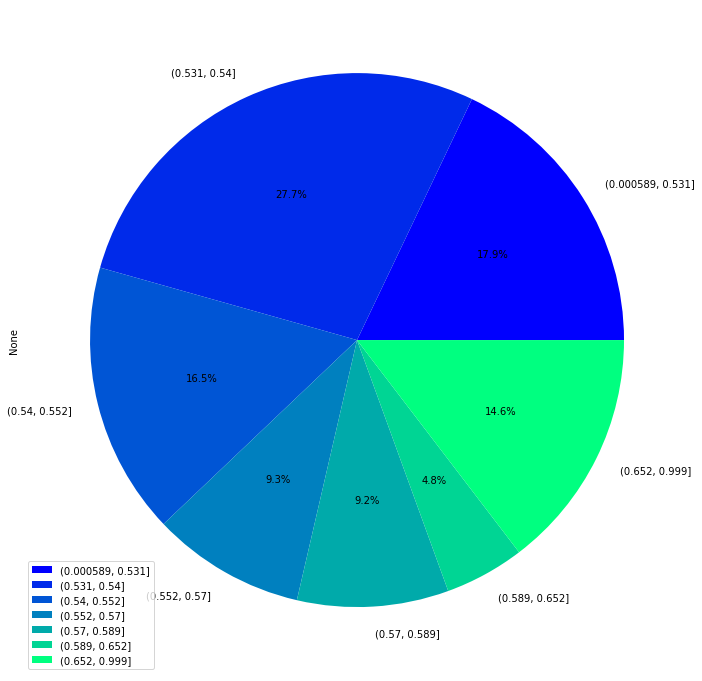

In [11]:
h_cc_,df_h_cc =compute_closeness_centrality(h_graph)

## Top 10 Distribution of node closeness centrality

The following barplot shows the concentration of .h nodes for the highest values of closeness centrality. It is evident that around 130 nodes between the .h files show a very high value of closeness centrality score, almost equal to 1.
The values of closeness centrality scores of the .h files are also a measure of similarity with respect to the .c files they are linked to. It is true that each node in the h_graph is connected to another .h file iff they share a common .c file.\
Following steps of our analysis will investigate the role of the most central files in the network.



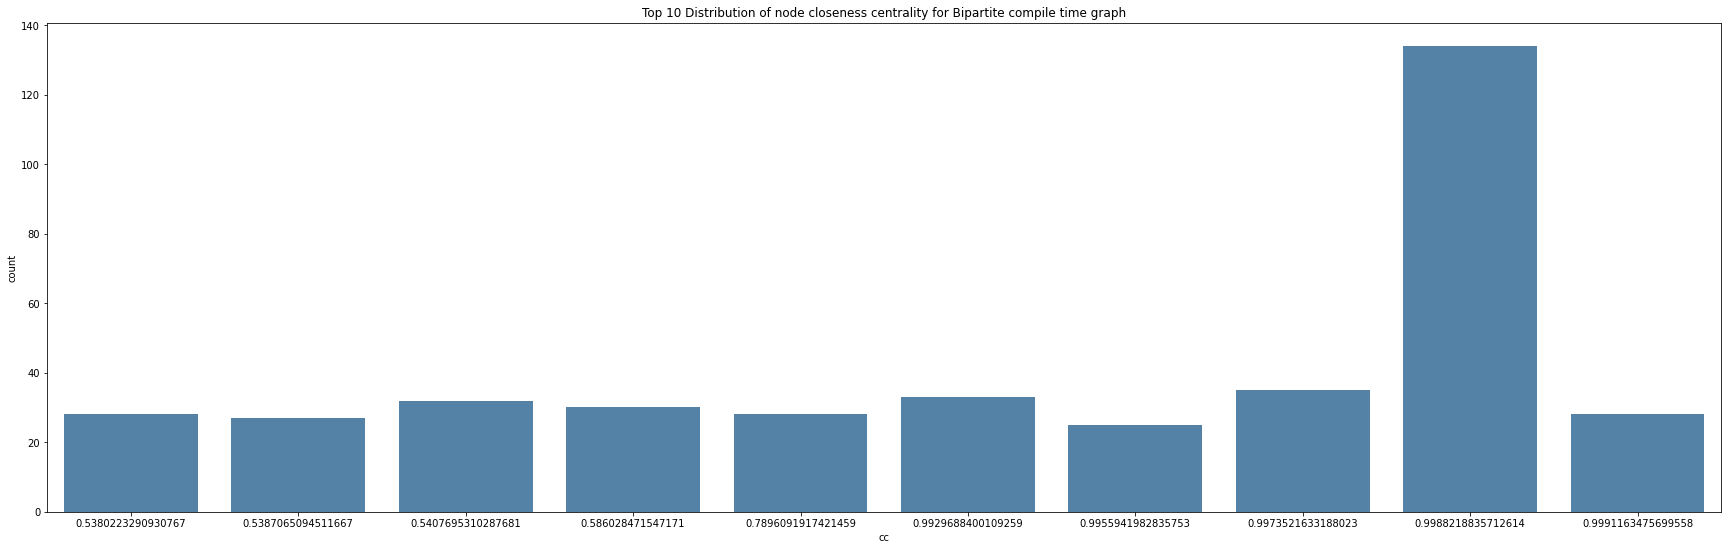

In [12]:
fig, ax = plt.subplots(figsize=(30, 9))
h_cc_count = df_h_cc.cc.value_counts().reset_index().rename(columns={'index':'cc', 'cc':'count'})
sns.barplot(x=h_cc_count.cc[:10], y=h_cc_count['count'][:10], color='steelblue')
ax.set_title('Top 10 Distribution of node closeness centrality for Bipartite compile time graph')
plt.show()

## Top 50 nodes with highest closeness centrality scores

In [13]:
df_h_cc.sort_values(by=['cc'],ascending=False)[:50]

,node,cc,central_range
656,edid.h,0.999116,"(0.652, 0.999]"
290,stddef.h,0.999116,"(0.652, 0.999]"
1187,cpufeatures.h,0.999116,"(0.652, 0.999]"
2303,page_types.h,0.999116,"(0.652, 0.999]"
3373,init.h,0.999116,"(0.652, 0.999]"
3329,edd.h,0.999116,"(0.652, 0.999]"
2520,kasan-checks.h,0.999116,"(0.652, 0.999]"
3054,bitsperlong.h,0.999116,"(0.652, 0.999]"
440,screen_info.h,0.999116,"(0.652, 0.999]"
2116,bootparam.h,0.999116,"(0.652, 0.999]"


Among these nodes we want to highlight some important files with important functions that could be the reason of their high centrality scores:
1. **linkage.h (linux/include/asm-i386/linkage.h)** defines the macro *asmlinkage* which tells the compiler to pass all function arguments on the stack.
2. **init.h** defines macros that serve to free up kernel memory.
3. **string.h** defines macros,constants and declarations of functions and types used not only for string handling but also various memory handling functions.
4. **stddef.h** header defines various variable types and macros e.g the **NULL** macro which is the value of a null pointer constant.
5. **types.h** defines data types used in system source code. Since some system data types are accessible to user code, they can be used to enhance portability across different machines and operating systems.


*References*:
1. https://www.cs.uic.edu/~tkhatiwa/kernel/kernel_gotchas.html
2. https://tldp.org/LDP/lkmpg/2.4/html/x281.htm
3. https://en.wikibooks.org/wiki/C_Programming/string.h#:~:text=h%20is%20the%20header%20in,thus%20something%20of%20a%20misnomer.
4. https://en.wikibooks.org/wiki/C_Programming/stddef.h#:~:text=h%20is%20a%20header%20file,ptrdiff_t%2C%20wchar_t%2C%20and%20size_t. && 
https://www.tutorialspoint.com/c_standard_library/stddef_h.htm
5. https://sites.ualberta.ca/dept/chemeng/AIX-43/share/man/info/C/a_doc_lib/files/aixfiles/types.h.htm#:~:text=Description,different%20machines%20and%20operating%20systems.

# 50 nodes with lowest closeness centrality scores

In [16]:
df_h_cc.sort_values(by=['cc'],ascending=False)[-50:]

,node,cc,central_range
2980,virtio_input.h,0.523398,"(0.000589, 0.531]"
2235,rc-core-priv.h,0.523317,"(0.000589, 0.531]"
381,tda18250_priv.h,0.523317,"(0.000589, 0.531]"
1265,tuner-i2c.h,0.523317,"(0.000589, 0.531]"
3131,lp.h,0.523317,"(0.000589, 0.531]"
1947,ni_tio_internal.h,0.523317,"(0.000589, 0.531]"
2809,u_uac2.h,0.523236,"(0.000589, 0.531]"
0,audio-v2.h,0.523236,"(0.000589, 0.531]"
2516,comedilib.h,0.523156,"(0.000589, 0.531]"
1596,fc0012-priv.h,0.523156,"(0.000589, 0.531]"
